# `keras_ocr`과 테서렉트를 사용해 OCR을 해봅시다!

이전 포스팅 : <https://butter-shower.tistory.com/173>


## 데이터셋 준비하기

사진 이미지는 `./data` 폴더에 저장해두었습니다.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os 

img_path = os.path.dirname(os.path.abspath('__file__')) + r'/data/ocr/'
img_path_list = []
for filename in os.listdir(img_path):
    tmp = img_path + filename
    img_path_list.append(tmp)

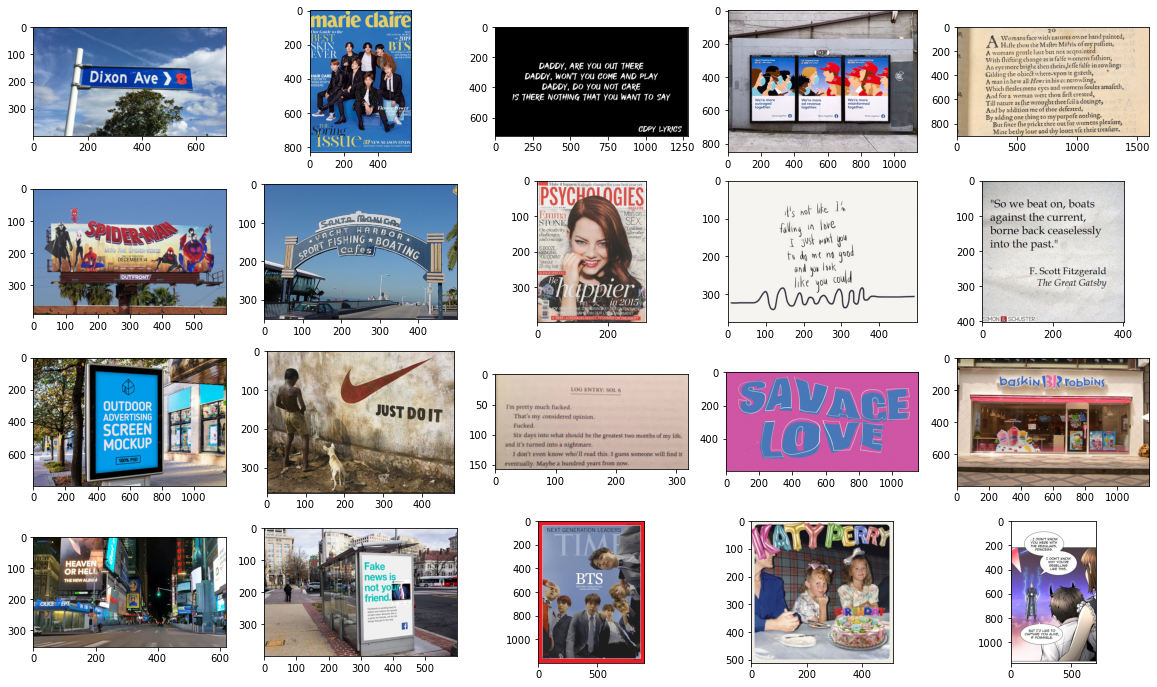

In [3]:
import matplotlib.image as mpimg

plt.figure(figsize = (20, 12))

for i in range(20):
    plt.subplot(4, 5, i+1)
    img = mpimg.imread(img_path_list[i])
    plt.imshow(img)

plt.show()

## keras-ocr 사용하기

keras-ocr은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해줍니다. 공식 문서에도 나와 있듯, 검출 모델로는 네이버 데뷰 2018 영상에서 소개한 CRAFT(Character Region Awareness for Text Detection)를 사용하고, 인식 모델로는 앞에서 설명한 CRNN을 사용합니다.

먼저 사용을 위해서 설치를 해 줍시다.

```bash
$ pip install keras-ocr
```

필요한 라이브러리인 `keras_ocr` 과 인식결과의 시각화를 위한 `matplotlib.pyplot` 를 불러옵니다. `keras_ocr.pipeline.Pipeline()` 는 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러오게 됩니다. 검출기와 인식기를 위한 가중치 하나씩을 불러오겠지요.


In [4]:
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel0039/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel0039/.keras-ocr/crnn_kurapan.h5


만들어둔 파이프라인의 `recognize()` 에 이미지를 넣어줍니다.

In [5]:
keras_images = [keras_ocr.tools.read(img) for img in img_path_list]

예시로 먼저 하나만 출력해봅시다!

In [10]:
prediction = pipeline.recognize([img_path_list[0]])

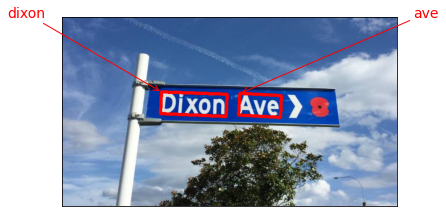

In [11]:
keras_ocr.tools.drawAnnotations(image=keras_images[0], predictions=prediction[0])

꽤 성능이 좋은 것 같습니다. 

이제 전체 이미지에 대해서도 한번 확인해봅시다.

In [12]:
prediction_groups = [pipeline.recognize([img]) for img in img_path_list]

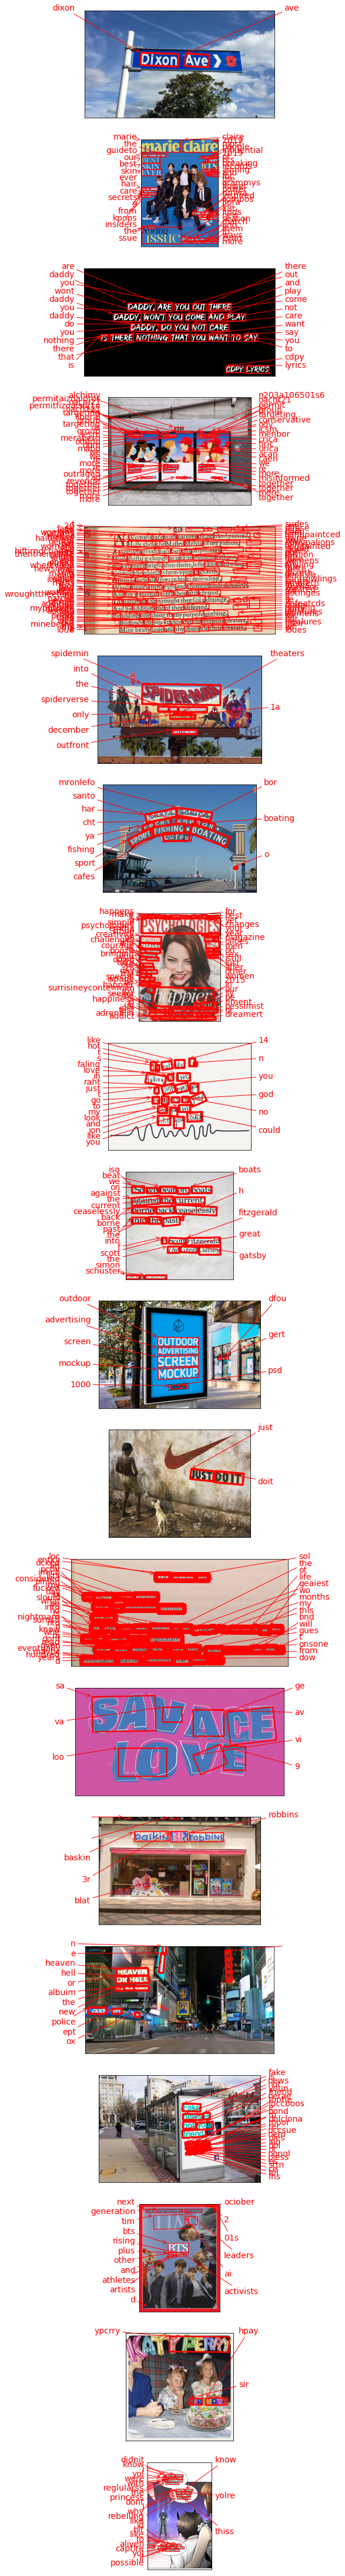

In [16]:
fig, axs = plt.subplots(nrows = 20, figsize = (20, 80))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=keras_images[idx], predictions=prediction_groups[idx][0], ax=ax)

평면 텍스트의 경우에는 잘 인식하지만, 풍선 글자 같은 경우에는 잘 인식하지 못하는 것으로 보입니다. 평면 텍스트의 경우, `'So~` 의 문장을 `iso`라고 인식하기도 하네요.

알록달록 구부러진 글자도 잘 이해하지 못하는 것 같습니다. (ex. savage love)

베스킨 라빈스의 BR 부분도 3r이라고 인식하고 있네요.

## 테서렉트 써보기

![IMG](https://aiffelstaticprd.blob.core.windows.net/media/original_images/E-19-15.png)

이번에는 테서랙트(Tesseract) 라이브러리로 이미지에서 문자를 인식해 보겠습니다. 테서랙트는 구글에서 후원하는 OCR 오픈소스 라이브러리로 현재는 버전 4와 Tessearct.js등으로 확장되는 등 많은 곳에서 사용되고 있습니다. 버전 4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함한 116 개 국어를 지원하고 있습니다.

오픈소스라는 점은 여러분들이 원하는 프로젝트에 활용하기 쉽다는 것을 뜻하니, 직접 해 보면서 익혀두면 나중에 간단한 OCR 모델이 필요할 때 빠르게 활용할 수 있을 겁니다.

### 테서렉트 설치하기

우선 우분투에서 실행할 경우 터미널에서 아래 코드를 사용해 테서랙트 관련 패키지들을 설치해 주세요. 혹시 다른 운영체제를 사용하실 경우에는 아래 Tesseract Install Guide를 참고해주세요.

- [Tesseract Install Guide](https://github.com/tesseract-ocr/tesseract/wiki)

```bash
$ sudo apt install tesseract-ocr
$ sudo apt install libtesseract-dev
```

### 테서렉트 파이썬 `wrapper` 설치하기

`Pytesseract`는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수있도록 해주는 래퍼 라이브러리(wrapper library)입니다. 파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해줍니다.

```bash
$ pip install pytesseract
```

### 테서렉트로 문자 검출하고 이미지 자르기 (detection)

테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있는데요. 우리는 OCR이 이뤄지는 전체과정을 직접 거쳐보기 위해 검출을 먼저 해 봅시다.


In [17]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

In [18]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

먼저 예시로 하나만 해봅시다!

In [28]:
custom_oem_psm_config = r'--oem 3 --psm 3'
image = Image.open(img_path_list[1])

recognized_data = pytesseract.image_to_string(
    image,
    lang = 'eng',
    config = custom_oem_psm_config,
    output_type = Output.DICT
)

print(recognized_data['text'])

( Pan

marie claire

as ELS wp the INFLUENTIAL, etl if

BEST i)

SIN

EVER
mi

 

Pre
PSe ta)
fa t0) el aecd

Ze 2

| SS SU (82 NEW SEASON FINDS
Re Pence asleren yo ea ean iat)

  

 



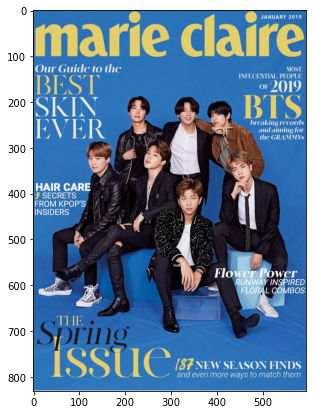

In [27]:
plt.figure(figsize=(5, 7))
plt.imshow(image)

어떤 것 같나요...? 별로 잘 하는 것 같진 않아보이죠?! 다른 이미지도 한번 봐봅시다.

In [30]:
custom_oem_psm_config = r'--oem 3 --psm 3'
image = Image.open(img_path_list[4])

recognized_data = pytesseract.image_to_string(
    image,
    lang = 'eng',
    config = custom_oem_psm_config,
    output_type = Output.DICT
)

print(recognized_data['text'])

 

x0 . +23
Womans face with natures owne hand painted,
Hafte thou the Mafter Mifris of my pafiion,
A womans gentle hatt but not acquainted
With fhifting change asis falfe womens fafhion,
An eyemore bright then theirs,lefle falfe in rowling:
Gilding the obiect where-vpon it gazeth,
A man in hew all Hews in his ccntrowling,
Which fteales mens eyes and womens foules amafeth,
And fora woman wert thou firft created,
Till nature as fhe wrought thee feiia dotinge,
And by addition me of thee defeated,
By adding one thing to my purpofe nothing.
But fince fhe prickt thee out for womens pleafure,
Mine bethy loue and thy loues vie their treafure.



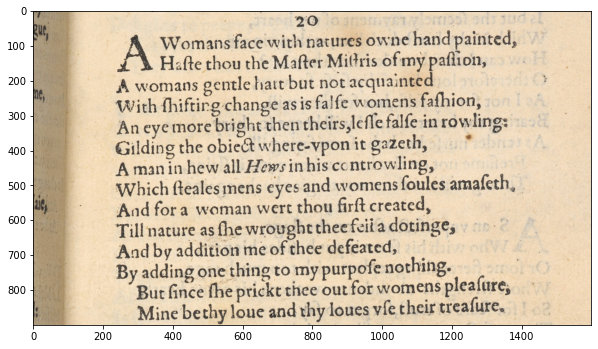

In [32]:
plt.figure(figsize=(10, 7))
plt.imshow(image)

평면 텍스트에 대해서는 매우 괜찮네요.

마지막으로 다른 이미지에 대해서도 한번 확인해봅시다.


"So we beat on, boats
against the current,
borne back ceaselessly
into the past."

F. Scott Fitzgerald
The Great Gatsby

SIMON E SCHUSTER



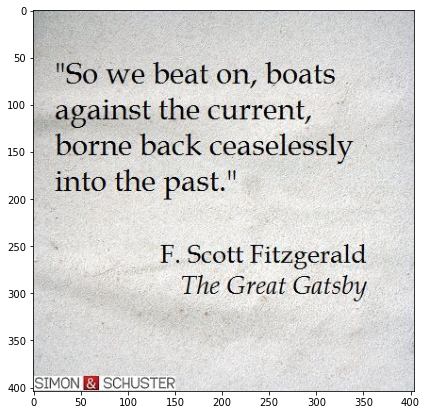

In [34]:
image = Image.open(img_path_list[9])

recognized_data = pytesseract.image_to_string(
    image,
    lang = 'eng',
    config = custom_oem_psm_config,
    output_type = Output.DICT
)

print(recognized_data['text'])

plt.figure(figsize=(10, 7))
plt.imshow(image)

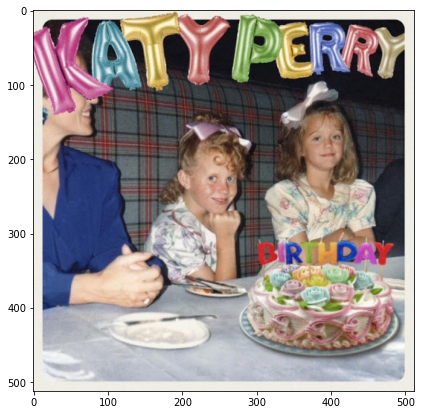

In [35]:
image = Image.open(img_path_list[18])

recognized_data = pytesseract.image_to_string(
    image,
    lang = 'eng',
    config = custom_oem_psm_config,
    output_type = Output.DICT
)

print(recognized_data['text'])

plt.figure(figsize=(10, 7))
plt.imshow(image)

## Conclusion

지금까지 OCR에 대해서 한번 살펴보았습니다.

google cloud의 vision api도 있지만 이것은 제가 api 설정이 제대로 안되어있는 관계로 이번 시간에서는 다루지 못했습니다.

`kreas_ocr`의 경우에는 길거리 텍스트에 대해서도 비교적 잘 읽는 반면, 테서렉트의 경우에는 그렇지 못했어요. 대신 평면 텍스트의 경우에선 테서렉트가 더 우위를 점하고 있는 것 같습니다.

지금까지 OCR에 대해서 살펴보았습니다. :)

In [36]:
from IPython.core.display import display, HTML
display(HTML("<style> .container{width:90% !important;}</style>"))